In [51]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [52]:
# Load vmem simulation data
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/vmem_data_neo' 

plot_vmem_file_paths = [
    os.path.join(base_dir, f'plot_data_neo_{i}.npy')
    for i in range(16)
]


vmem_amp_file_paths = [
    os.path.join(base_dir, f'vmem_amp_data_neo_Ez_{i}.npy')
    for i in range(16)
]

vmem_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in vmem_amp_file_paths
]
vmem_amp_data = {}
for data in vmem_amp_data_list:
    vmem_amp_data.update(data)

In [59]:
def scatter_plot_all_properties_with_reg(amp_data, properties, prop_names, at_freq=1000):
    """ Plots properties stored during simulation against the soma Vm amplitude at selected frequency (Figures C.11 and C.12)"""
    
    cols = 4
    rows = (len(properties)+3) //4

    # Initialize the figure
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4*cols, 4*rows), dpi=80)
    axes = axes.flatten()
    
    for ax, property_name in zip(axes, properties):
        x_values = []
        y_values = []
        for cell_name, values in amp_data.items():
                        
            property_value = values[property_name]
            
            if at_freq in values['freq']:  # Check if 1000 Hz frequency exists
                freq_idx = values['freq'].index(at_freq)
                soma_amp_at_freqHz = values['soma_amp'][freq_idx]

                if 'PC' in cell_name or 'SP' in cell_name:
                    color = 'tab:green'
                    label = 'Pyramidal cells'
                    alpha = 0.4
                elif 'SS' in cell_name:
                    color = 'tab:purple'
                    label = 'Spiny Stellate cells'
                    alpha = 0.9
                else:
                    color = 'tab:orange'
                    label = 'Inhibitory neurons'
                    alpha = 0.4
                
                ax.scatter(soma_amp_at_freqHz, property_value, label=label, marker = '.', color=color, alpha=alpha)
                x_values.append(soma_amp_at_freqHz)
                y_values.append(property_value)
        
        # Perform linear regression and calculate R² value
        if x_values and y_values:
            x_values_np = np.array(x_values).reshape(-1, 1)
            y_values_np = np.array(y_values)
            regressor = LinearRegression()
            regressor.fit(x_values_np, y_values_np)
            y_pred = regressor.predict(x_values_np)
            r2 = r2_score(y_values_np, y_pred)
            
            # Plot regression line
            ax.plot(x_values_np, y_pred, color='grey', linewidth=2)
            
            # Display R² value on the plot
            ax.text(0.05, 0.95, f'R²: {r2:.2f}', transform=ax.transAxes, fontsize=11,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        ax.set_xlabel(r'Soma $V_m$ Amplitude [mV]', fontsize=12)

        if property_name == 'asymmetry_factor':
            ax.set_ylabel(prop_names[property_name], fontsize=12)
        else: ax.set_ylabel(f'{prop_names[property_name]} [µm]', fontsize=12) # Units on everything but asymmetry factor
        
        # ax.grid()
        
        # Create a custom legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        if at_freq == 10:
            if property_name == 'asymmetry_factor':
                loc = 'lower right'
            else: loc = 'best'
        else:
            loc = 'upper right'
        ax.legend(by_label.values(), by_label.keys(), loc=loc)
    
    if at_freq == 10:
        fig_nr = 3
    else: fig_nr = 4
    plt.suptitle(f"Stimulation frequency {at_freq} Hz", fontsize=16)
    plt.tight_layout()
    plt.savefig(f'/Users/susannedahle/Documents/Master/Code/fig_pdfs/figS{fig_nr}.pdf', bbox_inches="tight")
    plt.show()


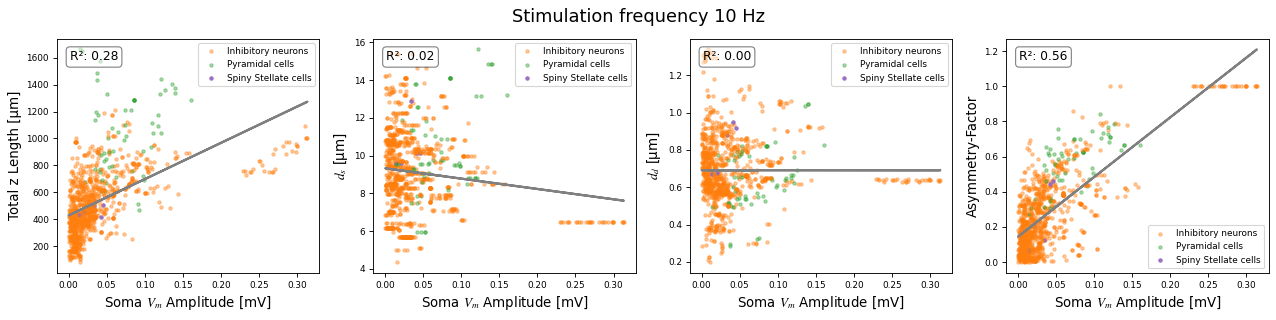

In [60]:
prop_names = {'total_len': 'Total z Length',  
              'asymmetry_factor': 'Asymmetry-Factor',
              'soma_diam': '$d_s$',
              'avg_z_diam': '$d_d$'}

selected_properties = ['total_len', 'soma_diam', 'avg_z_diam', 'asymmetry_factor']
scatter_plot_all_properties_with_reg(vmem_amp_data, selected_properties, prop_names, at_freq=10)

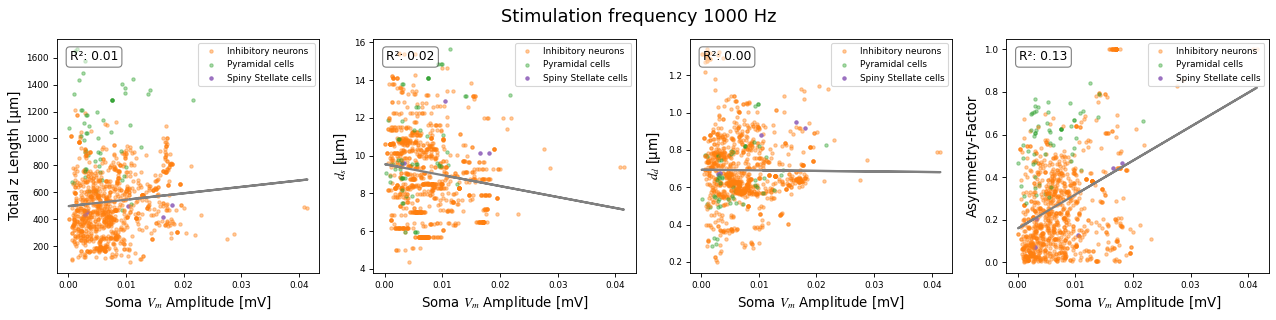

In [61]:
scatter_plot_all_properties_with_reg(vmem_amp_data, selected_properties, prop_names, at_freq=1000)